# 1. PyTorch Optimizer

In [ ]:
import torch
import torch.optim as optim

model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

for epoch in range(num_epochs):
  optimizer.zero_grad() # weight initialization
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward() # Backpropagation
  optimizer.step() # Weight update w/ optimizer

NameError: name 'MyModel' is not defined

In [ ]:
import torch
import torch.optim as optim

model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)


for epoch in range(num_epochs):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()

In [ ]:
import torch
import torch.optim as optim

model = MyModel()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, weight_decay=0.01)

for epoch in range(epochs):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()

### **Q1. Write a detailed explanation for**

optimizer = optim.Adam(model.parameters(), lr=0.001, bates=(0.9,0.999), weight_dacay=0.1)

다음은 학습 과정에서 사용할 최적화방법을 선택하는 코드입니다. Adam이라는 최적화 방법을 사용하고, 앞서 정의한 'model' 이라는 모델의 파라미터를 업데이트를 합니다. 이때 사용할 학습률은 0.001입니다.

2개의 베타값은 adam에서 각각의 가중치 업데이트 과정에서 사용되는 모멘텀 값과 학습률 감소 계수를 계산할 때 사용되는 상수입니다.

또한 정규화 과정에서 앞에 가중치 상쇠 상수를 곱해서 정규화 정도를 0.1로 조절하며 학습을 진행한다.

# 2. Revisiting Assignment1 MLP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device: ',DEVICE)

Using PyTorch version: 2.1.0+cu121 Device:  cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 148847232.35it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119581139.02it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40939876.14it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18750520.44it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


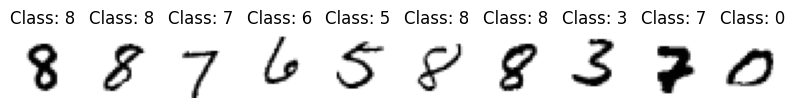

In [ ]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap = "gray_r")
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
'''Multi Layer Perceptron'''

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(28*28,512)
    self.fc2 = nn.Linear(512,256)
    self.fc3 = nn.Linear(256,10)

  def forward(self,x):
    x = x.view(-1,28*28)
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = self.fc3(x)
    x = F.log_softmax(x,dim = 1)
    return x

In [ ]:
'''Optimizer, Objective Function '''

model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
''' Learning rate Scheduler'''

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch : 0.95 ** epoch)

# 이 코드는 학습률을 에폭이 진행됨에 따라 줄여나갈 때 사용하는 코드, LambdaLR는 lambda값 (0.95)를 매 에폭마다 학습률에 곱해주어서 학습이 진행될 때 마다 학습률은 0.95배 만큼 exponential하게 줄어든다

In [ ]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()


    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(epoch, batch_idx * len(image),
                                                                           len(train_loader.dataset),
                                                                           100 * batch_idx/len(train_loader),
                                                                           loss.item()))
  scheduler.step()

In [ ]:
def evaluate(model, test_loader):
  model.eval() # 모델을 검증 모드로 전환 ( dropout = False )
  test_loss = 0
  correct = 0

  with torch.no_grad():
  # 검증이나 테스트 과정에서는 역전파가 필요하지 않기 때문에 다음 줄을 통해서 그라디언트를 저장하지 않음
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image) # output 계산
      test_loss += criterion(output, label).item() # 손실 함수로 출력과 정답의 오차 계산, loss_fn(output, target)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100 * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.376818
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.291075
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.318050
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.276193
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.268545
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.284736
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.289781
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.290393
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.252629
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.238158

[EPOCH: 1], 	Test Loss: 2.2336, 	Test Accuracy: 20.26 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.256887
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.220021
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.167574
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.147954
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.009770
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.918947
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.660687
T

### **Q2. Optimizer and Learning rate Scheduler**

(1) Change the Net model's optimizer to Adam optimizer and run the code.

(2)What is learning rate scheduler? Can you change the type of the scheduler in the code above? Also, write a detailed explanation of the scheduler to choose.

### **Optimizer : Adam, Learning rate scheduler : LambdaLR**

In [ ]:
'''Optimizer = Adam, Objective Function '''

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
''' Learning rate Scheduler'''

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch : 0.95 ** epoch)

# 이 코드는 학습률을 에폭이 진행됨에 따라 줄여나갈 때 사용하는 코드, LambdaLR는 lambda값 (0.95)를 매 에폭마다 학습률에 곱해주어서 학습이 진행될 때 마다 학습률은 0.95배 만큼 exponential하게 줄어든다

In [ ]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()


    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(epoch, batch_idx * len(image),
                                                                           len(train_loader.dataset),
                                                                           100 * batch_idx/len(train_loader),
                                                                           loss.item()))
  scheduler.step()

In [ ]:
def evaluate(model, test_loader):
  model.eval() # 모델을 검증 모드로 전환 ( dropout = False )
  test_loss = 0
  correct = 0

  with torch.no_grad():
  # 검증이나 테스트 과정에서는 역전파가 필요하지 않기 때문에 다음 줄을 통해서 그라디언트를 저장하지 않음
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image) # output 계산
      test_loss += criterion(output, label).item() # 손실 함수로 출력과 정답의 오차 계산, loss_fn(output, target)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100 * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \tWith Adam\n".format(
      epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.311462
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.809921
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.455205
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.551633
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.303937
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.372450
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.060889
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.223225
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.055217
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.285703

[EPOCH: 1], 	Test Loss: 0.1646, 	Test Accuracy: 94.98 % 	With Adam

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.153708
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.172021
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.419695
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.083215
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.025714
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.124230
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 

### **Optimizer : Adam, Learning rate scheduler : ExponentialLR**

In [ ]:
'''Optimizer = Adam, Objective Function '''

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
''' Learning rate Scheduler : Cosine Annealing LR'''

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# 이 코드는 학습률을 에폭이 진행됨에 따라 줄여나갈 때 사용하는 코드, LambdaLR는 lambda값 (0.95)를 매 에폭마다 학습률에 곱해주어서 학습이 진행될 때 마다 학습률은 0.95배 만큼 exponential하게 줄어든다

In [ ]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()


    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(epoch, batch_idx * len(image),
                                                                           len(train_loader.dataset),
                                                                           100 * batch_idx/len(train_loader),
                                                                           loss.item()))
  scheduler.step()

In [ ]:
def evaluate(model, test_loader):
  model.eval() # 모델을 검증 모드로 전환 ( dropout = False )
  test_loss = 0
  correct = 0

  with torch.no_grad():
  # 검증이나 테스트 과정에서는 역전파가 필요하지 않기 때문에 다음 줄을 통해서 그라디언트를 저장하지 않음
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image) # output 계산
      test_loss += criterion(output, label).item() # 손실 함수로 출력과 정답의 오차 계산, loss_fn(output, target)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100 * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \tWith Adam\n".format(
      epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.289669
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.358255
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.334120
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.269485
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.340698
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.161506
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.272829
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.140831
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.082428
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.029996

[EPOCH: 1], 	Test Loss: 0.1374, 	Test Accuracy: 95.76 % 	With Adam

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.014811
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.041405
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.012520
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.024583
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.014271
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.082940
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 